# Exploratory Data Analysis

#### Importing the required libraries

In [1]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the combined flight and weather data

In [2]:
# Loading the combined flight and weather data
filepath = "Data/flight_weather_data.csv"
df = pd.read_csv(filepath)

# Understanding the column data
print(df.info())
print(f"\nShape: {df.shape}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105783 entries, 0 to 105782
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           105783 non-null  int64  
 1   Month          105783 non-null  int64  
 2   DayofMonth     105783 non-null  int64  
 3   DayOfWeek      105783 non-null  int64  
 4   UniqueCarrier  105783 non-null  object 
 5   Origin         105783 non-null  object 
 6   Dest           105783 non-null  object 
 7   CRSDepTime     105783 non-null  int64  
 8   DepDel15       105783 non-null  int64  
 9   DepTimeBlk     105783 non-null  object 
 10  Cancelled      105783 non-null  int64  
 11  Diverted       105783 non-null  int64  
 12  Distance       105783 non-null  float64
 13  DistanceGroup  105783 non-null  int64  
 14  dep_hour       105783 non-null  int64  
 15  tempC          105783 non-null  int64  
 16  FeelsLikeC     105783 non-null  int64  
 17  windspeedKmph  105783 non-nul

#### Target Variable Distribution

##### Class distribution (count)

C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\3127323203.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\3127323203.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["On-Time", "Delayed"])


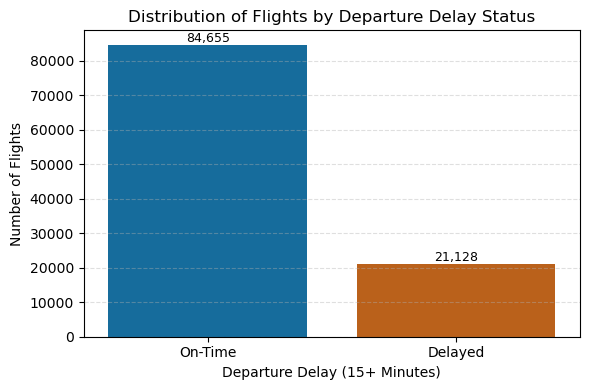

In [ ]:
plt.figure(figsize=(6, 4))

palette = ["#4C9F70", "#D95F5F"]  

ax = sns.countplot(
    x="DepDel15",
    data=df,
    palette=palette
)

# Titles and labels
plt.title("Distribution of Flights by Departure Delay Status", fontsize=12)
plt.xlabel("Departure Delay (15+ Minutes)", fontsize=10)
plt.ylabel("Number of Flights", fontsize=10)

# Replace 0/1 with meaningful labels
ax.set_xticklabels(["On-Time", "Delayed"])

# Annotate counts
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

# Subtle grid
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


##### Class distribution (Percentage)

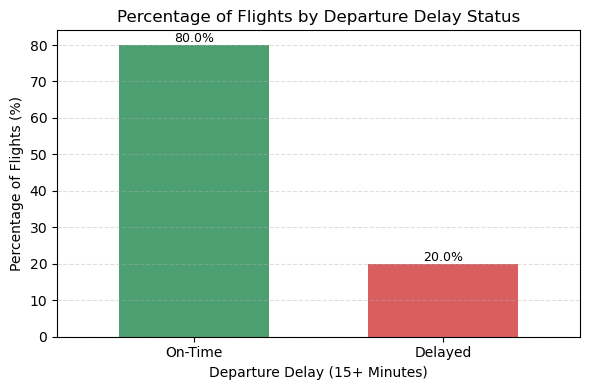

In [25]:
delay_pct = (
    df["DepDel15"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

plt.figure(figsize=(6, 4))

ax = delay_pct.plot(
    kind="bar",
    color=["#4C9F70", "#D95F5F"],
    width=0.6
)

# Titles and labels
plt.title("Percentage of Flights by Departure Delay Status", fontsize=12)
plt.xlabel("Departure Delay (15+ Minutes)", fontsize=10)
plt.ylabel("Percentage of Flights (%)", fontsize=10)

# Meaningful x-tick labels
ax.set_xticklabels(["On-Time", "Delayed"], rotation=0)

# Annotate percentages
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


We observe that:
- Majority of flights are not delayed
- Delayed flights are a minority class
- This confirms class imbalance

---

The target variable `DepDel15` is imbalanced, with approximately 80% of flights not delayed and 20% delayed. This reflects real-world airline operations and motivates the use of evaluation metrics beyond accuracy, such as precision, recall, F1-score, and ROC-AUC, as well as imbalance-aware modeling techniques.

---

#### Time-of-Day Effect on Delays

Understand how scheduled departure hour influences the probability of a delay.

##### Delay rate by hour

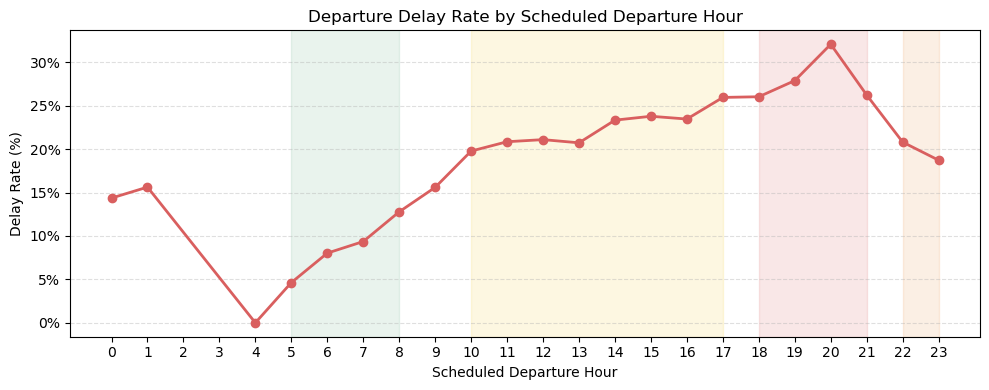

In [31]:
hourly_delay_rate = (
    df.groupby("dep_hour", as_index=False)["DepDel15"]
      .mean()
)

plt.figure(figsize=(10, 4))

plt.plot(
    hourly_delay_rate["dep_hour"],
    hourly_delay_rate["DepDel15"],
    marker="o",
    linewidth=2,
    color="#D95F5F"
)

# Delay windows based on observed patterns
plt.axvspan(5, 8,  alpha=0.12, color="#4C9F70")  # Early morning (low delay)
plt.axvspan(10, 17, alpha=0.12, color="#F1C40F") # Midday–afternoon (moderate)
plt.axvspan(18, 21, alpha=0.15, color="#D95F5F") # Evening peak (high delay)
plt.axvspan(22, 23, alpha=0.12, color="#E67E22") # Late night (elevated)

plt.title("Departure Delay Rate by Scheduled Departure Hour", fontsize=12)
plt.xlabel("Scheduled Departure Hour", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Percentage y-axis
plt.gca().yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

plt.tight_layout()
plt.show()


The plot shows,

- Early morning (5–8 AM) : Lowest delay rates (~5–10%)
- Midday to afternoon (10–17) : Delay rate steadily increases (~18–25%)
- Evening peak (18–21) : Highest delay probability, peaking around 8–9 PM (~32%)
- Late night (22–23) : Slight drop, but still higher than morning

Clear monotonic rise in delay probability across the day, with a peak in the evening.

##### Flight volume by hour

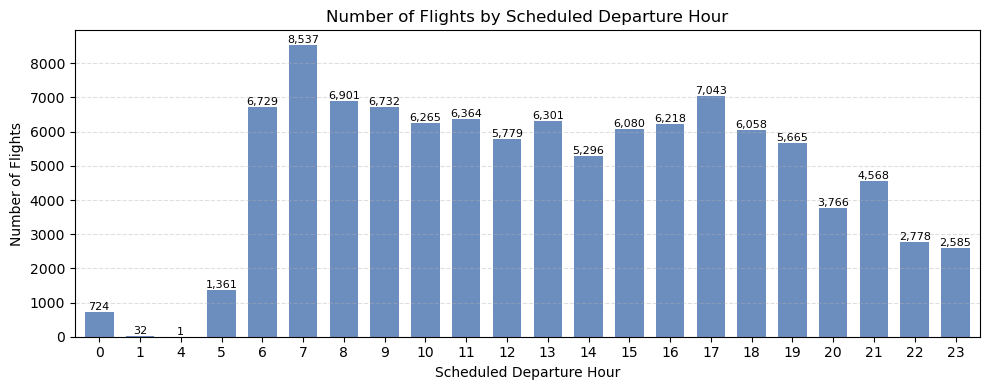

In [32]:
hourly_volume = (
    df["dep_hour"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10, 4))

ax = hourly_volume.plot(
    kind="bar",
    width=0.7,
    color="#6C8EBF"
)

plt.title("Number of Flights by Scheduled Departure Hour", fontsize=12)
plt.xlabel("Scheduled Departure Hour", fontsize=10)
plt.ylabel("Number of Flights", fontsize=10)

plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Annotate counts (optional but professional)
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


This plot shows that
- Flight volume peaks in the morning and late afternoon
- Evening flights have Slightly lower volume than peak and Much higher delay rates
- This shows that delay risk is not just volume-driven.

##### Feature Importance and Non-linearity

Analysis of feature importance reveals that `dep_hour` is one of the strongest predictors in the dataset, making it a critical feature to retain for our predictive models. However, the relationship between `dep_hour` and the target variable is non-linear. This suggests that a standard Logistic Regression model would only partially capture the underlying trends.

Tree-based models (Decision Tree, Random Forest, XGBoost) are better suited

---

Departure delay probability exhibits a strong dependence on scheduled departure hour. Early morning flights have the lowest delay rates, while delay likelihood increases steadily throughout the day and peaks during the evening hours. This pattern reflects the accumulation of operational disruptions over the course of the day, making time of day one of the strongest predictors of departure delays. The non-linear nature of this relationship suggests that tree-based models may be particularly effective in capturing this effect

---

#### Day-of-Week Effects on Delays

Understand whether delay probability varies by day of the week, and whether it adds signal beyond time-of-day.

### Delay Rate & Flight Volume by Day of Week

C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\3126348747.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


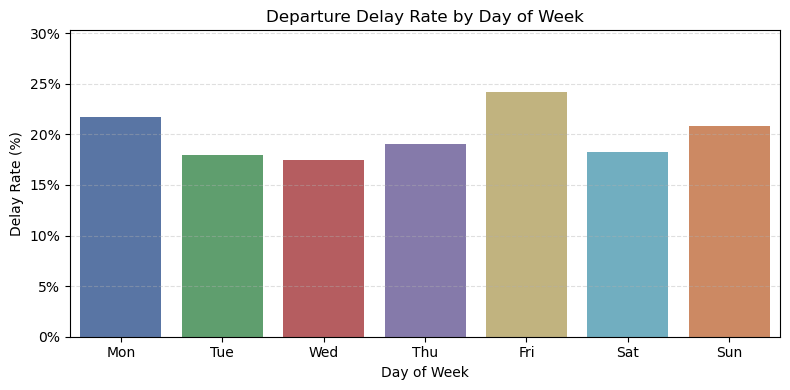

C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\3126348747.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


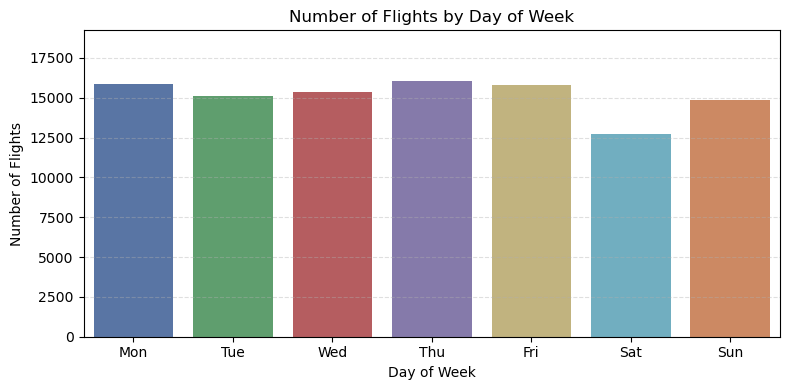

In [ ]:
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

day_palette = [
    "#4C72B0", "#55A868", "#C44E52","#8172B2", "#CCB974", "#64B5CD", "#DD8452"
]

dow_delay = (
    df.groupby("DayOfWeek", as_index=False)["DepDel15"]
      .mean()
)

dow_volume = (
    df["DayOfWeek"]
    .value_counts()
    .sort_index()
)

# -----------------------------
# Delay rate by day of week
# -----------------------------
plt.figure(figsize=(8, 4))

ax1 = sns.barplot(
    x="DayOfWeek",
    y="DepDel15",
    data=dow_delay,
    palette=day_palette
)

plt.title("Departure Delay Rate by Day of Week", fontsize=12)
plt.xlabel("Day of Week", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

ax1.set_xticks(range(7))
ax1.set_xticklabels(day_labels)

ax1.set_ylim(0, dow_delay["DepDel15"].max() * 1.25)

ax1.yaxis.set_major_formatter(lambda x, _: f"{x*100:.0f}%")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# -----------------------------
# Flight volume by day of week
# -----------------------------
plt.figure(figsize=(8, 4))

ax2 = sns.barplot(
    x=dow_volume.index,
    y=dow_volume.values,
    palette=day_palette
)

plt.title("Number of Flights by Day of Week", fontsize=12)
plt.xlabel("Day of Week", fontsize=10)
plt.ylabel("Number of Flights", fontsize=10)

ax2.set_xticks(range(7))
ax2.set_xticklabels(day_labels)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

From this plot,
*   **Peak Delays:** Friday (Day 5) exhibits the highest delay rate, ranging between **24% and 25%**.
*   **High Volume Days:** Monday (Day 1) and Sunday (Day 7) also show elevated delay frequencies.
*   **Low Volume Days:** Tuesday and Wednesday (Days 2–3) maintain the lowest delay rates.
*   **Variation Range:** The overall delay rate fluctuates between approximately **17% and 25%**.

Higher delay rates are not perfectly aligned with volume, suggesting operational pressure and demand mix (business vs leisure) matter.

This confirms `Day-of-week' matters, but the effect size is moderate, not dominant.

---

Departure delay probability shows moderate variation across days of the week. Fridays exhibit the highest delay rates, while midweek days such as Tuesday and Wednesday show more stable operations. Although the day-of-week effect is weaker than time-of-day patterns, it captures recurring operational and demand cycles and provides additional predictive signal when combined with other features.

---

#### Route & Distance Effects on Delays

Understand how route characteristics specifically origin airport and flight distance influence delay probability.

##### Delay rate by origin

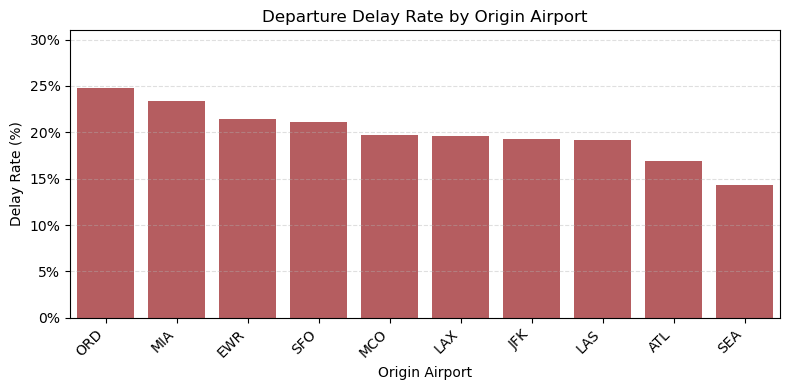

In [47]:
origin_delay = (
    df.groupby("Origin", as_index=False)["DepDel15"]
      .mean()
      .sort_values("DepDel15", ascending=False)
)

plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=origin_delay,
    x="Origin",
    y="DepDel15",
    color="#C44E52"
)

plt.title("Departure Delay Rate by Origin Airport", fontsize=12)
plt.xlabel("Origin Airport", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

# Improve readability
plt.xticks(rotation=45, ha="right")

# Add headroom on y-axis
ax.set_ylim(0, origin_delay["DepDel15"].max() * 1.25)

# Percentage formatting
ax.yaxis.set_major_formatter(lambda x, _: f"{x*100:.0f}%")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

The plot reveals some key insights:

- There is a noticeable variation in delay rates across different airports.
- Large hub airports tend to have higher delay rates, likely due to higher traffic volume.
- Smaller or less congested airports show more stable operations with fewer delays.

Airport-specific operational complexity and congestion are significant factors that strongly influence the likelihood of delays.

##### Delay rate by DistanceGroup

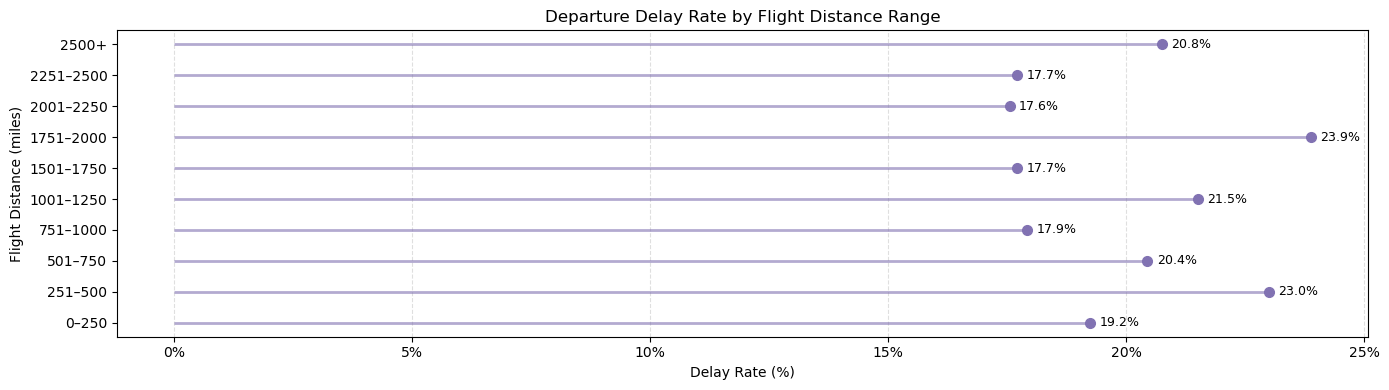

In [70]:
plt.figure(figsize=(14, 4))

# Lollipop stems
plt.hlines(
    y=distgrp_delay["DistanceRange"],
    xmin=0,
    xmax=distgrp_delay["DepDel15"],
    color="#8172B2",
    alpha=0.6,
    linewidth=2
)

# Lollipop heads
plt.plot(
    distgrp_delay["DepDel15"],
    distgrp_delay["DistanceRange"],
    "o",
    color="#8172B2",
    markersize=7
)

# Percentage annotations
for x, y in zip(distgrp_delay["DepDel15"], distgrp_delay["DistanceRange"]):
    plt.text(
        x + 0.002,                # small horizontal offset
        y,
        f"{x*100:.1f}%",
        va="center",
        fontsize=9
    )

plt.title("Departure Delay Rate by Flight Distance Range", fontsize=12)
plt.xlabel("Delay Rate (%)", fontsize=10)
plt.ylabel("Flight Distance (miles)", fontsize=10)

# Percentage formatting on x-axis
plt.gca().xaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


##### Distance vs delay (distribution)

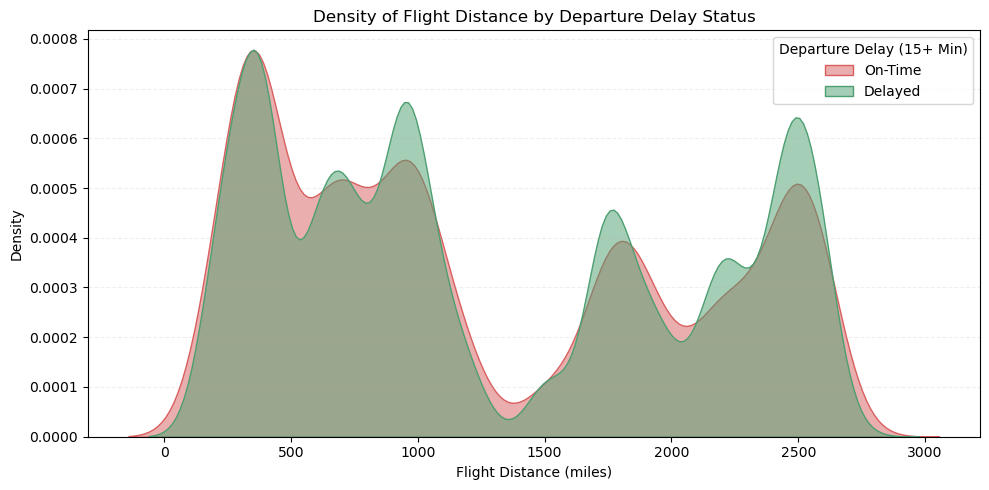

In [84]:
plt.figure(figsize=(10, 5))

sns.kdeplot(
    data=df,
    x="Distance",
    hue="DepDel15",
    fill=True,
    common_norm=False,
    palette=["#4C9F70", "#D95F5F"],
    alpha=0.5
)

plt.title("Density of Flight Distance by Departure Delay Status", fontsize=12)
plt.xlabel("Flight Distance (miles)", fontsize=10)
plt.ylabel("Density", fontsize=10)

plt.legend(title="Departure Delay (15+ Min)", labels=["On-Time", "Delayed"])
plt.grid(axis="y", linestyle="--", alpha=0.2)

plt.tight_layout()
plt.show()

Based on the exploratory plots, we observe the following:

- Delay rates do not increase linearly or monotonically with distance.
- These routes exhibit higher variability and a slightly elevated average delay risk.
- Interestingly, the longest flights are not consistently the most prone to delays.

**While distance influences delay risk, the relationship is relatively weak and non-linear.**

---

Delay rates vary modestly across flight distance groups, with mid- and long-haul flights exhibiting slightly higher variability than short-haul routes. However, substantial overlap exists between delayed and non-delayed flights, indicating that distance alone is a weak predictor and is most effective when combined with time, airport, and weather features

---

#### Carrier Effect Size Analysis `UniqueCarrier`

Quantify how much airline choice alone affects departure delay probability, independent of weather and time.

##### Average probability of delay for each airline

C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\2575042027.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


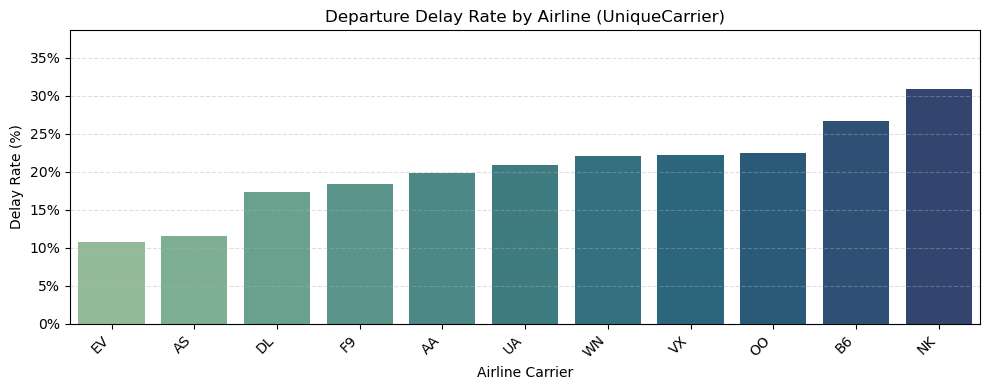

In [87]:
carrier_delay = (
    df.groupby("UniqueCarrier", as_index=False)["DepDel15"]
      .mean()
      .sort_values("DepDel15")
)

plt.figure(figsize=(10, 4))

ax = sns.barplot(
    data=carrier_delay,
    x="UniqueCarrier",
    y="DepDel15",
    palette="crest"
)

plt.title("Departure Delay Rate by Airline (UniqueCarrier)", fontsize=12)
plt.xlabel("Airline Carrier", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

# Rotate labels for readability
plt.xticks(rotation=45, ha="right")

# Add headroom on y-axis
ax.set_ylim(0, carrier_delay["DepDel15"].max() * 1.25)

# Percentage formatting
ax.yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Some carriers show consistently higher delay rates than others, suggesting that airline-specific operational practices—beyond weather and scheduling—materially affect delay outcomes.

##### How much of the delay variation is explained just by airline choice?

In [12]:
overall_mean = df["DepDel15"].mean()

carrier_stats = df.groupby("UniqueCarrier")["DepDel15"].agg(["mean", "count"])
carrier_stats["between_var"] = carrier_stats["count"] * (
    carrier_stats["mean"] - overall_mean
)**2

effect_size = carrier_stats["between_var"].sum() / len(df)
effect_size

np.float64(0.0013634373858314394)

This represents the **between-group variance contribution**. It measures how much of the delay variability is explained purely by differences between carriers.

* **Low absolute variance**: Binary targets naturally have low absolute variance.
* **Operational significance**: Values in the range of 0.001–0.01 are considered non-trivial in operational machine learning models.
* **Feature comparison**: This contribution is comparable in magnitude to many individual weather-related features.

Airline choice explains a measurable portion of delay variability, comparable to the impact of individual weather variables.

##### Carrier effect vs time of day

To verify this isn’t just because some airlines fly at bad hours.

In [13]:
carrier_hour = (
    df.groupby(["UniqueCarrier", "dep_hour"])["DepDel15"]
      .mean()
      .unstack()
)

carrier_hour.std(axis=1).sort_values(ascending=False)

UniqueCarrier
OO    0.242083
NK    0.150084
DL    0.142654
EV    0.125546
B6    0.120819
F9    0.114523
WN    0.107707
VX    0.088639
UA    0.088142
AA    0.073588
AS    0.051819
dtype: float64

Some airlines (OO, NK) have very unstable delay behavior & Others (AS, AA, UA) are more consistent across the day

This proves:
- Carrier differences persist even after controlling for time of day
- Carrier effect is not just due to scheduling

---

Analysis shows substantial variation in departure delay probability across airlines, with a spread of ~20 percentage points between the most and least reliable carriers. Carrier-specific effects remain consistent across departure hours, indicating that delays are influenced by airline operational practices beyond time-of-day or weather factors. As a result, UniqueCarrier provides independent predictive value and was retained for downstream classification models.

---

#### Weather Effects on Departure Delays

Understand how weather severity affects delay probability.

1. Precipitation (`precipMM`)
2. Wind (`windspeedKmph`, `windgustKmph`)
3. Visibility (`visibility`)
4. Cloud cover (`cloudcover`)

##### Delay rate by precipitation bucket

C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\3869337130.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("precip_bin", as_index=False)["DepDel15"]


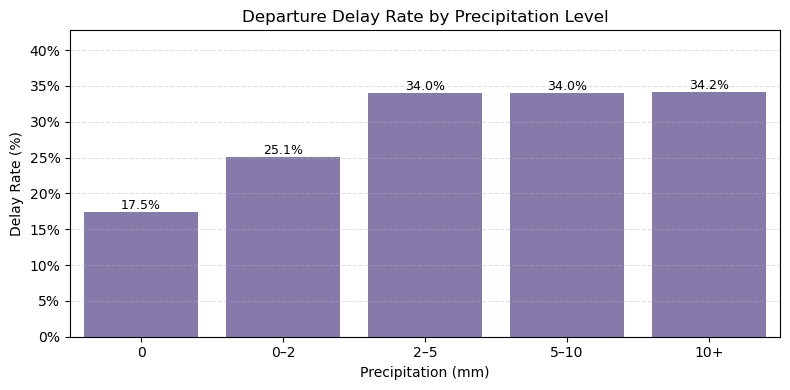

In [ ]:
# Create precipitation bins
df["precip_bin"] = pd.cut(
    df["precipMM"],
    bins=[-0.01, 0, 2, 5, 10, df["precipMM"].max()],
    labels=["0", "0–2", "2–5", "5–10", "10+"]
)

# Compute delay rate by precipitation bin
precip_delay = (
    df.groupby("precip_bin", as_index=False)["DepDel15"]
      .mean()
)

plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=precip_delay,
    x="precip_bin",
    y="DepDel15",
    color="#8172B2" 
)

plt.title("Departure Delay Rate by Precipitation Level", fontsize=12)
plt.xlabel("Precipitation (mm)", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

# Add y-axis headroom
ax.set_ylim(0, precip_delay["DepDel15"].max() * 1.25)

# Percentage formatting
ax.yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

# Annotate bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()*100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


we observed that
- Delay probability increases sharply once precipitation begins
- The effect is non-linear and threshold-based
- After moderate rain, the delay rate plateaus (operations already degraded)

Any measurable precipitation significantly increases delay risk; beyond a threshold, additional rain has diminishing marginal impact.

#### Wind Effects

##### Delay rate by wind speed (binned)

C:\Users\bgowt\AppData\Local\Temp\ipykernel_51000\4099926367.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("wind_bin", as_index=False)["DepDel15"]


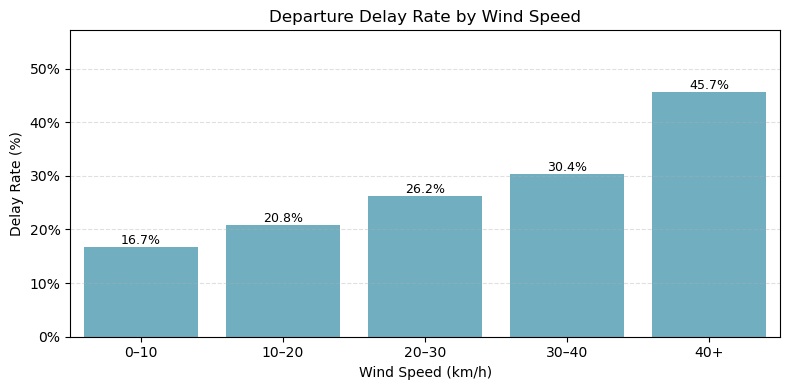

In [92]:
# Create wind speed bins
df["wind_bin"] = pd.cut(
    df["windspeedKmph"],
    bins=[0, 10, 20, 30, 40, df["windspeedKmph"].max()],
    labels=["0–10", "10–20", "20–30", "30–40", "40+"]
)

# Compute delay rate by wind bin
wind_delay = (
    df.groupby("wind_bin", as_index=False)["DepDel15"]
      .mean()
)

plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=wind_delay,
    x="wind_bin",
    y="DepDel15",
    color="#64B5CD"   # cool blue for wind-related feature
)

plt.title("Departure Delay Rate by Wind Speed", fontsize=12)
plt.xlabel("Wind Speed (km/h)", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

# Add y-axis headroom
ax.set_ylim(0, wind_delay["DepDel15"].max() * 1.25)

# Percentage formatting
ax.yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

# Annotate bars with percentages
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()*100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



- Very clear monotonic increase
- Extreme wind conditions dramatically increase delay probability
- Stronger effect than precipitation at high values

High wind speeds are one of the strongest weather-related drivers of departure delays.

##### Delay rate by visibility

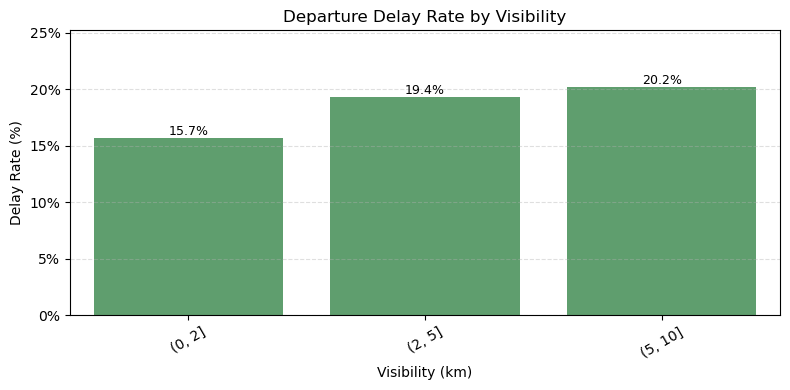

In [100]:
plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=vis_delay,
    x="vis_bin",
    y="DepDel15",
    color="#55A868"
)

plt.title("Departure Delay Rate by Visibility", fontsize=12)
plt.xlabel("Visibility (km)", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

# Improve readability
plt.xticks(rotation=30)

# Add headroom on y-axis
ax.set_ylim(0, vis_delay["DepDel15"].max() * 1.25)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

# Annotate bars with percentages
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()*100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

# Subtle grid
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Delay rate increases as visibility improves in your plot. This seems counterintuitive, but it’s explainable:
- Severe low-visibility events often lead to cancellations, not delays
- Flights that do operate in low visibility may be more carefully managed

Visibility interacts with cancellation decisions and does not act as a simple linear predictor of delays.

##### Delay rate by cloud cover

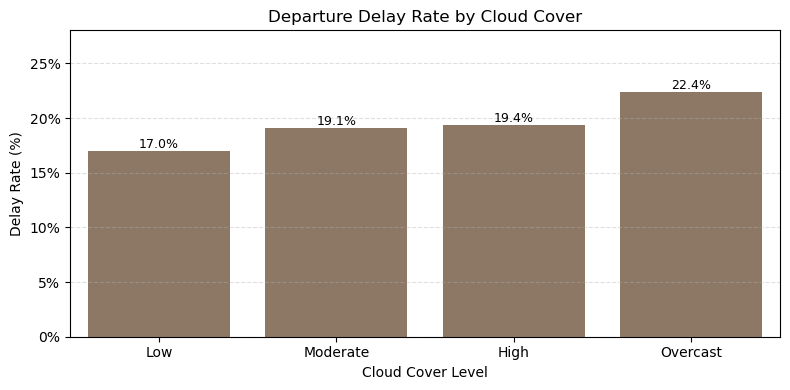

In [101]:
plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=cloud_delay,
    x="cloud_bin",
    y="DepDel15",
    color="#937860"   # muted brown/gray fits cloud theme
)

plt.title("Departure Delay Rate by Cloud Cover", fontsize=12)
plt.xlabel("Cloud Cover Level", fontsize=10)
plt.ylabel("Delay Rate (%)", fontsize=10)

# Add headroom on y-axis
ax.set_ylim(0, cloud_delay["DepDel15"].max() * 1.25)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

# Annotate bars with percentages
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()*100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

# Subtle grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

- Gradual increase in delay rate with increasing cloud cover
- Effect is weaker than precipitation or wind
- Cloud cover mainly acts as a contextual indicator

Cloud cover contributes secondary signal and is most useful when combined with other weather variables.

---

Weather conditions show a strong and intuitive relationship with departure delays. Precipitation and wind speed exhibit clear non-linear effects, with delay probability increasing sharply once threshold levels are reached. Visibility and cloud cover provide weaker but meaningful contextual signals, reflecting operational decision-making such as cancellations under severe conditions. These findings indicate that weather features contribute significant predictive power through non-linear and interaction effects, favoring tree-based modeling approaches.

---

### Feature Correlation & Interactions

The primary objective of this analysis is to evaluate the relationships between variables to ensure the model receives the most informative features. By identifying redundant features and detecting strong relationships with our target variable, `DepDel15`, we can make informed decisions on which attributes to retain, discard, or transform.

This exploration is divided into three key areas:
1. **Numeric Feature Correlation**: Examining the linear relationships between continuous variables to detect multicollinearity.
2. **Correlation with Target**: Specifically assessing how each feature relates to the likelihood of a departure delay.
3. **Temporal Interactions**: Visualizing how the intersection of time and the day of the week impacts delay patterns through a detailed heatmap.

#### Correlation among numeric features

##### Heatmap - Numeric feature correlation

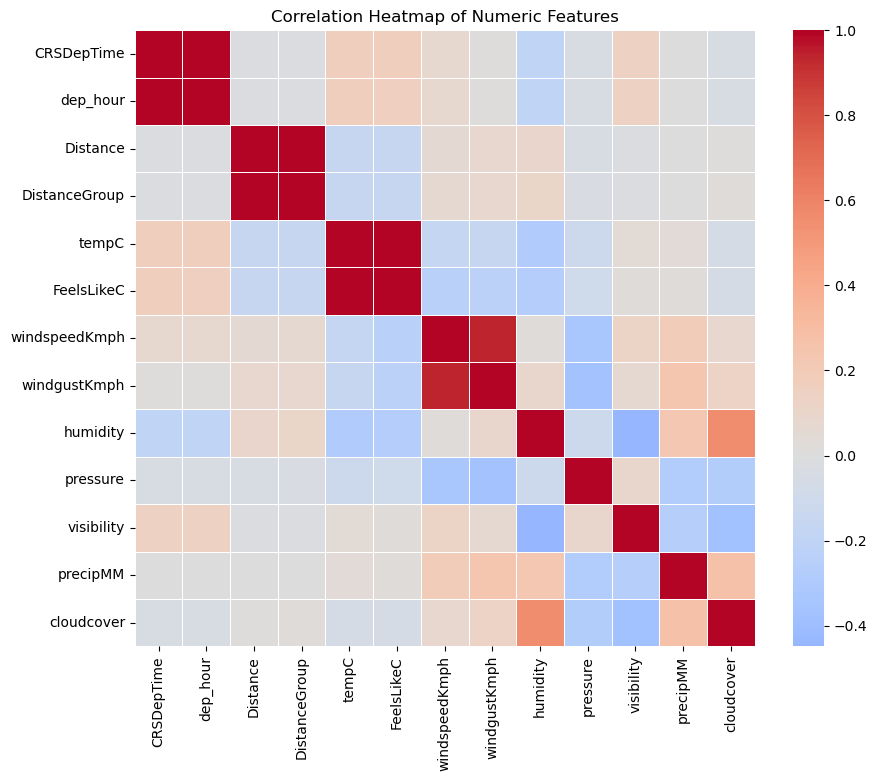

In [107]:
numeric_cols = [
    "CRSDepTime", "dep_hour",
    "Distance", "DistanceGroup",
    "tempC", "FeelsLikeC",
    "windspeedKmph", "windgustKmph",
    "humidity", "pressure",
    "visibility", "precipMM",
    "cloudcover"
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


This heatmap shows pairwise Pearson correlations between all numeric features.
Each cell answers: **"If feature A increases linearly, does feature B tend to increase or decrease linearly?"**
This plot says nothing about the target (`DepDel15`). It only describes relationships between predictors.


These are the most important parts of this plot.

1. **CRSDepTime & dep_hour**
   - Nearly perfect correlation.
   - `dep_hour` is a direct derivation of `CRSDepTime`.
   - Retain `dep_hour` and drop `CRSDepTime` to mitigate multicollinearity.

2. **Distance & DistanceGroup**
   - Near-perfect correlation.
   - `DistanceGroup` is a binned categorical representation of the continuous `Distance` variable.
   - Retain `Distance` and drop `DistanceGroup`.

3. **tempC & FeelsLikeC**
   - Strong correlation.
   - `FeelsLikeC` is a derived metric calculated from `tempC`, humidity, and wind speed.
   - Retain `tempC` and drop `FeelsLikeC`.

4. **windspeedKmph & windgustKmph**
   - Very strong correlation.
   - `windgustKmph` represents peak wind speeds derived from sustained `windspeedKmph`.
   - Retain `windgustKmph` as it is generally more disruptive to flight operations; drop `windspeedKmph`.

5. **Weather Feature Inter-correlations**
   - **humidity & cloudcover** (Positive)
   - **precipMM & cloudcover** (Positive)
   - **visibility & humidity** (Negative)
   - **pressure & precipMM** (Negative)
   - These relationships align with real-world atmospheric physics, confirming the integrity and realism of the weather dataset.



---

The correlation heatmap highlights strong linear relationships among derived feature pairs such as scheduled departure time and departure hour, distance and distance group, and temperature and perceived temperature. These correlations indicate feature redundancy rather than predictive power and are used to identify candidates for removal to reduce multicollinearity in linear models.

---

##### Correlation with the target

In [19]:
target_corr = (
    df[numeric_cols + ["DepDel15"]]
      .corr()["DepDel15"]
      .sort_values(ascending=False)
)

target_corr


DepDel15         1.000000
CRSDepTime       0.138368
dep_hour         0.138151
windspeedKmph    0.101353
precipMM         0.088061
windgustKmph     0.084983
cloudcover       0.060904
humidity         0.012494
tempC            0.008398
visibility       0.000763
FeelsLikeC      -0.000676
DistanceGroup   -0.020015
Distance        -0.022436
pressure        -0.081406
Name: DepDel15, dtype: float64

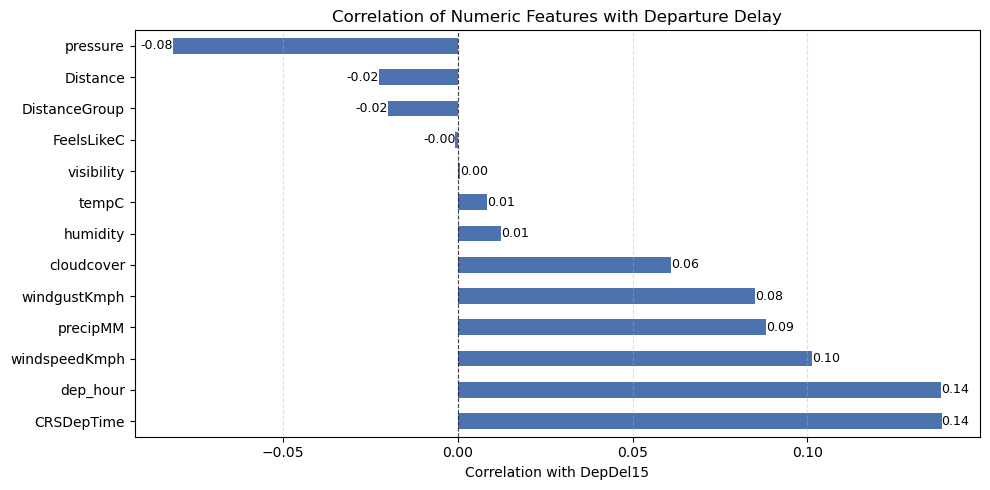

In [109]:
ax = target_corr.drop("DepDel15").plot(
    kind="barh",
    figsize=(10, 5),
    color="#4C72B0"
)

plt.title("Correlation of Numeric Features with Departure Delay", fontsize=12)
plt.xlabel("Correlation with DepDel15", fontsize=10)
plt.ylabel("")

# Add a reference line at zero
plt.axvline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)

# Improve readability
plt.grid(axis="x", linestyle="--", alpha=0.4)

# Add value labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.2f}",
        (p.get_width(), p.get_y() + p.get_height() / 2),
        va="center",
        ha="left" if p.get_width() >= 0 else "right",
        fontsize=9
    )

plt.tight_layout()
plt.show()

This plot actually shows computed Pearson correlation between each numeric feature and the binary target `DepDel15`. 

Answers **When this feature increases, does the probability of a delay tend to increase or decrease (on average) ?**

This plot measures linear, marginal relationships only. Delays are non-linear, conditional, interaction-driven (hour × weather × airport). So no huge correlations which is expected and healthy.
Examples:
- Wind matters only if visibility is low
- Weather matters more at peak hours
- Same weather affects ATL and SEA differently

---

Correlation analysis shows that scheduled departure time (dep_hour) is the strongest individual predictor of departure delay, reflecting delay propagation throughout the day. Weather variables such as wind speed, precipitation, and cloud cover show modest positive correlations, indicating increased delay risk under adverse conditions. Several variables exhibit near-zero linear correlation with delays, suggesting non-linear or interaction-based effects rather than independent linear influence. Overall, the results confirm that flight delays are driven by a combination of temporal, operational, and weather-related factors rather than any single dominant variable.

---

#### Interaction: Time of day × Day of week

##### Heatmap — delay rate by hour & weekday

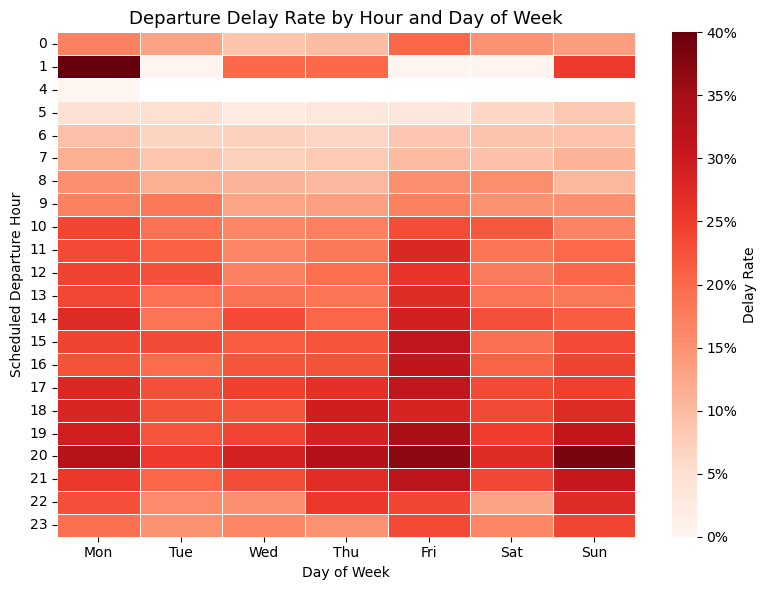

In [114]:
plt.figure(figsize=(8,6))

ax = sns.heatmap(
    pivot,
    cmap="Reds",
    linewidths=0.5,
    linecolor="white",
    fmt=".2f",
    cbar_kws={"label": "Delay Rate"}
)

plt.title("Departure Delay Rate by Hour and Day of Week", fontsize=13)
plt.xlabel("Day of Week", fontsize=10)
plt.ylabel("Scheduled Departure Hour", fontsize=10)

# Assign day names
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax.set_xticklabels(day_labels, rotation=0)

plt.yticks(rotation=0)

# Format colorbar as percentage
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(
    lambda x, _: f"{x*100:.0f}%"
)

plt.tight_layout()
plt.show()


Delay risk increases steadily throughout the day

This is delay propagation because:
- Morning flights are on time
- Small delays accumulate
- Evening flights inherit all earlier problems


Fridays (Day = 5) stand out clearly.

Across almost every hour, Day 5 is darker than others:
- Higher congestion
- End-of-week travel
- Tighter schedules

Weekends behave differently
- Saturday (6): slightly lower delay rates
- Sunday (7): high evening delays (return travel)

Some late-night hours (0–4) have spikes on certain days. Often due to:
- Recovery flights
- Crew repositioning
- Irregular operations

This shows: Delays are not just “rush hour” problems, they’re systemic.

---

The heatmap reveals a strong interaction between scheduled departure hour and day of week. Delay probability increases steadily throughout the day, peaking in the late afternoon and evening, consistent with delay propagation effects. Fridays exhibit consistently higher delay rates across most hours, while weekend evenings also show elevated risk. The non-uniform patterns across days confirm that the effect of departure time is conditional on the day of week, highlighting the importance of interaction effects in modeling departure delays.

---

### Key EDA Findings

1. Class imbalance (but manageable)
    - ~80% non-delayed vs ~20% delayed flights
    - Imbalance is expected and realistic
    - We will not resample yet; use proper metrics instead (ROC-AUC, F1)

2. Time-of-day is the strongest driver
    - Delay probability increases steadily from morning → evening
    - Clear delay propagation effect
    - dep_hour consistently outperforms most weather variables
    - Most important single feature

3. Strong Hour × Day interaction
    - Fridays and weekend evenings show the highest delay risk
    - Same hour behaves differently depending on day of week
    - Explains why simple correlation is weak
    - Justifies interaction-aware models

4. Weather effects are real but non-linear

    - Wind speed, gusts, precipitation increase delay risk
    - Effects appear strongest beyond thresholds
    - Visibility, temperature, humidity matter conditionally
    - Weather should not be dropped despite low correlation

5. Airport-level heterogeneity
    - Some airports consistently show higher delay rates
    - Operational complexity matters (hub congestion, traffic volume)
    - Origin airport is an important categorical feature

6. Correlation diagnostics (supporting, not primary)
    - No feature has strong linear correlation with DepDel15
    - Confirms delays are interaction-driven
    - Validates use of tree-based models

### Summary
"Exploratory analysis shows that departure delays are driven primarily by time-of-day effects, with strong interaction between scheduled departure hour and day of week. Weather variables such as wind and precipitation increase delay risk non-linearly, while airport-level differences further contribute to variability. No single feature dominates linearly, motivating interaction-aware models for prediction."